In [1]:
from modules.dataloader import XView3Data
import numpy as np
from torch.utils.data import DataLoader
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from modules.metric import score, compute_loc_performance
import numpy as np
from tqdm import tqdm
import cv2, os
import rasterio
from rasterio.enums import Resampling
import torchvision
from torch.utils.tensorboard import SummaryWriter
import joblib

In [2]:
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 TITAN Xp
1 TITAN X (Pascal)
2 Quadro K420


/home/xview3/anaconda3/envs/xview3/lib/python3.9/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 Quadro K420 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [3]:
device_DN = torch.device("cuda:1")
device_RPN = torch.device("cuda:1")

## Model Preparation

In [4]:
from torchvision.models import resnet50
from torchvision import io, transforms as T

transform = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# img = io.read_image("./lion.jpg")/255
# img = transform(img).reshape(1,3,224,224)
# img = img.to(device)

In [5]:
from modules.featextract import FeatureExtractor
from modules.model import RPN, DN
from modules.config import load_model_config
from modules.utils import evaluate, save_fig, convert_prob_to_image, prepare_label

In [6]:
def prepare_backbone():
    backbone = resnet50(pretrained=True)
    for param in backbone.parameters():
        param.requires_grad = False
    backbone = backbone.eval()
    
    return backbone

In [64]:
rpn = torch.nn.Sequential(*[FeatureExtractor(load_model_config(prepare_backbone())), RPN(128)])
rpn.load_state_dict(torch.load("/media/xview/xview3_challenge/xView3-Challenge/exps/ckpts/RPN_4_trained_model_3_epochs.pth"))
rpn.to(device_RPN)
rpn.eval()
print()

In [7]:
# dn = torch.nn.Sequential(*[FeatureExtractor(load_model_config(prepare_backbone())), DN(128, 4)])
# dn.load_state_dict(torch.load("/media/xview/xview3_challenge/xView3-Challenge/exps/ckpts/DN_3_trained_model_3_epochs.pth"))
# dn.to(device_DN)
# dn.eval()
# print()

## Dataloading

In [8]:
def preprocess_label(df):
    df = df.dropna(subset=["is_vessel"])
    return df


val_data_path = "/media/xview/xview3_challenge/dataset/data/validation"
val_label_path = "/media/xview/xview3_challenge/dataset/labels/validation.csv"


val_data = XView3Data(background_chip_ratio=1.1, obj_size=5, threshold=0.25, overwrite=False,
                        labels_path=val_label_path, data_path=val_data_path, preprocess_label=preprocess_label, shore=True)



dataset = val_data

Total scenes detected: 50
	Processing scene: 36076e547370064ev
	Loading labels from json
	Total chips extracted: 154
		Background chips: 18
		Foreground chips: 180
	Processing scene: 758991708403f218v
	Loading labels from json
	Total chips extracted: 101
		Background chips: 10
		Foreground chips: 94
	Processing scene: 7b7e837a7ac5a880v
	Loading labels from json
	Total chips extracted: 116
		Background chips: 12
		Foreground chips: 112
	Processing scene: 3fe00bf7beab8812v
	Loading labels from json
	Total chips extracted: 152
		Background chips: 18
		Foreground chips: 172
	Processing scene: 4a97701b4bd81bf7v
	Loading labels from json
	Total chips extracted: 82
		Background chips: 10
		Foreground chips: 91
	Processing scene: 335f9a411884e9cbv
	Loading labels from json
	Total chips extracted: 75
		Background chips: 10
		Foreground chips: 91
	Processing scene: 75c03770095c6d9ev
	Loading labels from json
	Total chips extracted: 30
		Background chips: 4
		Foreground chips: 40
	Processing scen

In [18]:
def load_uid(uid, rpn=False):
    scene_id, chip_row, chip_col = uid.split("_")
    chip_row, chip_col = int(chip_row), int(chip_col)
    
    scene = dataset.scenes[scene_id]
    rgb_img, flag = scene[chip_row, chip_col]
    
    (strt_r, strt_c), _ = scene.get_full_index(chip_row, chip_col)
    
    with torch.no_grad():
        rgb_img = torch.from_numpy(np.expand_dims(rgb_img, 0))
        
        img = transform(rgb_img)
        labels = scene.labels[uid]
        class_labels, _ = prepare_label(labels, dataset.chipsize, 
                                            dataset.obj_size, dataset.threshold, fishing=True)
        if rpn:
            class_labels[class_labels != 0] = 1
            class_labels = torch.from_numpy(class_labels.astype("float32"))
        else:
            class_true = torch.from_numpy(class_labels)
        
    return rgb_img, class_labels

In [19]:
# data_ixs = joblib.load("dataset_ixs.joblib")

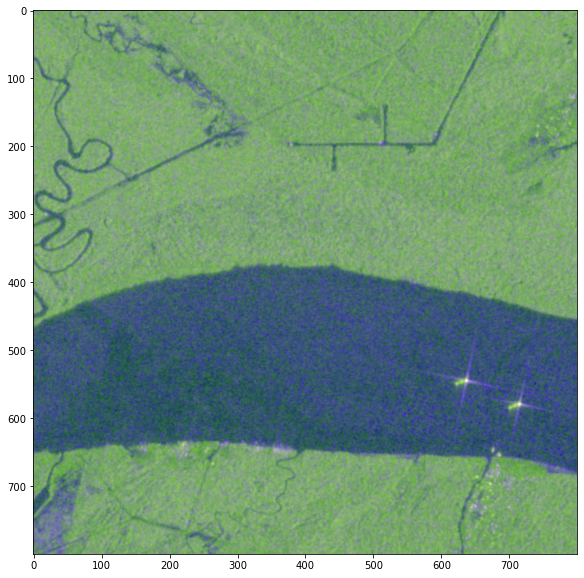

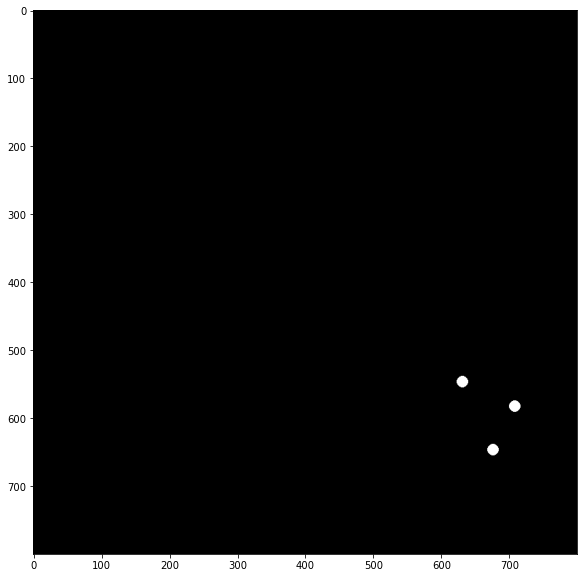

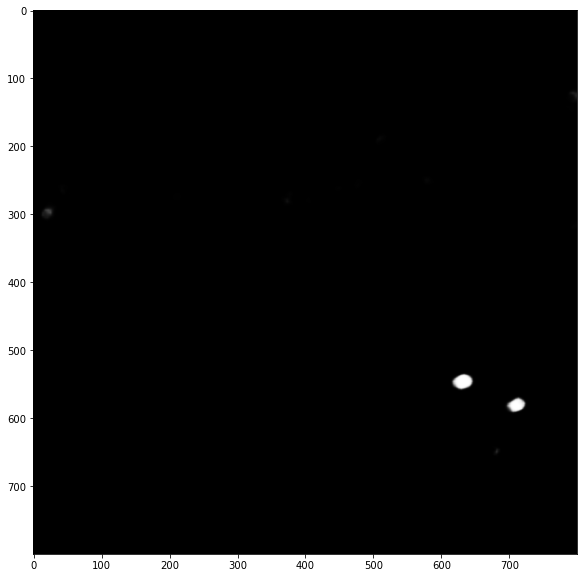

In [65]:
rgb_img, class_labels = load_uid(dataset.shore_ixs[1100], True)

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(rgb_img.numpy()[0], (1,2,0)), cmap="gray")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(class_labels, cmap="gray")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(rpn(transform(rgb_img.to(device_RPN))).cpu().detach().numpy().squeeze(), cmap="gray")
plt.show()